In [1]:
import numpy as np
import nltk
import pandas as pd
nltk.download('punkt')

import os
import re
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [4]:
test = pd.read_json("test-data.json","r", encoding="utf8")
train = pd.read_json("train-data.json","r", encoding="utf8")

In [5]:
df = pd.concat([test,train])

In [6]:
def clean_text(text):
    text = text.lower() 
    text = re.sub("[^a-zA-Z]"," ",text)
    text = re.sub(' +', ' ', text)
    return text.strip()

def cleaner(text):
    text = clean_text(text)
    words = nltk.word_tokenize(text)
    return " ".join(words)

df["question"] = df["corrected_question"].apply(lambda x:  cleaner(x) )
df["query"] = df["sparql_query"].apply(lambda x:  cleaner(x) )

In [7]:
df["question"]

0       which architect of marine corps air station ka...
1       which sects people are part of local political...
2       list common systems are developed by of the go...
3       for which games are sam loyd and eric schiller...
4              is peter piper pizza in the pizza industry
                              ...                        
3995    name the actors of the tv show which has an ep...
3996     how many religion s people have died in malaysia
3997       name the hbo tv show written by erik jendresen
3998    how many different currencies are used in the ...
3999            list the team for which doug acomb played
Name: question, Length: 5000, dtype: object

In [8]:
encoder_input_text = df["question"].to_numpy()
decoder_input_text = df["query"].to_numpy()

In [9]:
def tagger(decoder_input_sentence):
  bos = "STARTXX "
  eos = " ENDXXX"
  final_target = [bos + text + eos for text in decoder_input_sentence] 
  return final_target

decoder_input_text = tagger(decoder_input_text)

VOCAB_SIZE = 50000
from keras.preprocessing.text import Tokenizer


def vocab_creater(text_lists, VOCAB_SIZE):
  tokenizer = Tokenizer(num_words=VOCAB_SIZE)
  tokenizer.fit_on_texts(text_lists)
  dictionary = tokenizer.word_index

  word2idx = {}
  idx2word = {}
  for k, v in dictionary.items():
      if v < VOCAB_SIZE:
          word2idx[k] = v
          idx2word[v] = k
      if v >= VOCAB_SIZE-1:
          continue
          
  return word2idx, idx2word

word2idx, idx2word = vocab_creater(text_lists=np.concatenate( (encoder_input_text,decoder_input_text)  ), VOCAB_SIZE=VOCAB_SIZE)

#Redefine .....
VOCAB_SIZE = len(idx2word) +1

In [10]:
len(word2idx)

7416

In [11]:
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(np.concatenate( (encoder_input_text,decoder_input_text)))
encoder_sequences = tokenizer.texts_to_sequences(encoder_input_text);
decoder_sequences = tokenizer.texts_to_sequences(decoder_input_text);

from keras.preprocessing.sequence import pad_sequences
#MAX_LEN
encoder_input_data = pad_sequences(encoder_sequences, dtype='int32', padding='post', truncating='post')
MAX_LEN = encoder_input_data.shape[1]
decoder_input_data = pad_sequences(decoder_sequences, maxlen=MAX_LEN, dtype='int32', padding='post', truncating='post')


In [12]:
MAX_LEN

24

In [13]:
print(decoder_input_data[0].shape)
print(decoder_input_data.shape)

(24,)
(5000, 24)


In [58]:
from glove import Corpus, Glove

sentences = []
for x in df["question"]:
  sentences.append(x.split(" "))


for x in df["query"]:
  sentences.append(x.split(" "))

#Creating a corpus object
corpus = Corpus() 

#Training the corpus to generate the co occurence matrix which is used in GloVe
corpus.fit(sentences, window=10)

glove = Glove(no_components=100, learning_rate=0.1) 
glove.fit(corpus.matrix, epochs=30, no_threads=4, verbose=True)
glove.add_dictionary(corpus.dictionary)
with open("results_glove.txt", "w") as f:
    for word in glove.dictionary:
        f.write(word)
        f.write(" ")
        for i in range(0, 100):
            f.write(str(glove.word_vectors[glove.dictionary[word]][i]))
            f.write(" ")
        f.write("\n")

Performing 30 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29


In [42]:
sentences

[['which',
  'architect',
  'of',
  'marine',
  'corps',
  'air',
  'station',
  'kaneohe',
  'bay',
  'was',
  'also',
  'tenant',
  'of',
  'new',
  'sanno',
  'hotel'],
 ['which',
  'sects',
  'people',
  'are',
  'part',
  'of',
  'local',
  'political',
  'parties',
  'which',
  'fall',
  'under',
  'the',
  'international',
  'muslim',
  'brotherhood'],
 ['list',
  'common',
  'systems',
  'are',
  'developed',
  'by',
  'of',
  'the',
  'google',
  'videos',
  'and',
  'written',
  'by',
  'of',
  'the',
  'google',
  'web',
  'toolkit'],
 ['for',
  'which',
  'games',
  'are',
  'sam',
  'loyd',
  'and',
  'eric',
  'schiller',
  'both',
  'famous'],
 ['is', 'peter', 'piper', 'pizza', 'in', 'the', 'pizza', 'industry'],
 ['name',
  'the',
  'artist',
  'who',
  'made',
  'dream',
  'dancing',
  'and',
  'is',
  'often',
  'associated',
  'with',
  'joe',
  'pass'],
 ['who',
  'is',
  'the',
  'office',
  'holder',
  'with',
  'deputies',
  'as',
  'neil',
  'brown',
  'and',
  '

array([ 0.03992567, -0.01777165, -0.01148028, -0.0086503 , -0.00390664,
        0.02393462, -0.03715279, -0.01220778,  0.03559455,  0.02686015,
       -0.00163339,  0.01419421,  0.0135874 , -0.05763464, -0.01482372,
       -0.00592172,  0.00069532,  0.0266104 , -0.01294323, -0.01722647,
       -0.00748083,  0.02012582,  0.00035605,  0.00873835, -0.00287075,
       -0.01419219, -0.03794296,  0.00857172,  0.01057432,  0.02107152,
        0.00270305,  0.03540613, -0.01012224,  0.01213264,  0.00965199,
        0.00499201,  0.00519285,  0.00585078, -0.00140282,  0.00874587,
        0.0008327 , -0.01012411, -0.00599633, -0.01549727, -0.00050594,
       -0.01678362,  0.02239135, -0.02032521, -0.04002773,  0.00096889,
        0.01554506, -0.02641084, -0.02772833,  0.00778398, -0.00533796,
        0.01322484, -0.01123898,  0.04274735, -0.05532886, -0.0469038 ,
        0.00185508, -0.00701993, -0.02565431,  0.01698282,  0.02269512,
       -0.00470217,  0.02606211, -0.00871811,  0.0073166 , -0.01

In [61]:
def glove_100d_dictionary(GLOVE_DIR):
  embeddings_index = {}
  f = open(os.path.join(GLOVE_DIR, 'results_glove.txt'))
  for line in f:
      values = line.split()
      word = values[0].lower()
      coefs = np.asarray(values[1:], dtype='float32')
      embeddings_index[word] = coefs
  f.close()
  return embeddings_index

embeddings_index = glove_100d_dictionary("/content")
embeddings_index

{'which': array([ 0.29293928,  0.32754937,  0.21712044,  0.4304587 ,  0.32167247,
         0.69283956, -0.26057327,  0.3419282 , -0.29560488, -0.24422054,
        -0.01241651, -0.22825278,  0.35176238, -0.17789553,  0.44805828,
         0.25058475,  0.54151535,  0.15572473, -0.19126798, -0.34561524,
        -0.3937699 , -0.36783805, -0.01880256, -0.51073   , -0.53757644,
        -0.04515601, -0.09112518, -0.14697221,  0.03597642, -0.14908856,
        -0.15286817,  0.21527384,  0.01459174,  0.3515892 ,  0.4828052 ,
         0.21364537,  0.15505049, -0.09707251,  0.437687  ,  0.10215051,
         0.51814055, -0.23146735,  0.01108222,  0.19208029, -0.4382903 ,
         0.09735902,  0.43881238,  0.36585122, -0.6534997 ,  0.13457006,
        -0.26247132, -0.3513722 ,  0.2178921 , -0.43721896, -0.5396671 ,
        -0.37239984, -0.43329394, -0.16010115,  0.02829843, -0.01071882,
        -0.04430947,  0.37864146,  0.31631932, -0.18560486, -0.23095936,
         0.03890445, -0.28002098, -0.99548

In [62]:
def embedding_matrix_creater(embedding_dimention):
  embedding_matrix = np.zeros((len(word2idx) + 1, embedding_dimention))
  for word, i in word2idx.items():
      embedding_vector = embeddings_index.get(word)
      if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
          embedding_matrix[i] = embedding_vector
  return embedding_matrix
  
embedding_matrix = embedding_matrix_creater(100)
embedding_matrix

array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-4.70275670e-01,  4.59848374e-01,  3.19310725e-01, ...,
         3.81297976e-01,  4.48383480e-01,  6.10119402e-01],
       [-4.13176805e-01,  3.75071049e-01,  3.16786051e-01, ...,
         4.79581445e-01,  2.96457916e-01, -2.48423412e-01],
       ...,
       [ 5.75994812e-02, -4.66535389e-02, -4.24224697e-02, ...,
        -2.22947914e-02, -4.95437309e-02, -9.35681723e-03],
       [ 4.90523614e-02, -4.76311669e-02, -4.39096689e-02, ...,
        -2.48194356e-02, -4.44848612e-02,  1.64316967e-02],
       [ 6.32419363e-02, -4.89478149e-02, -5.32302819e-02, ...,
        -3.72287929e-02, -6.02145195e-02,  2.13732797e-04]])

In [63]:
from tensorflow.keras import backend as k
from tensorflow.keras import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *

In [93]:
def embedding_layer_creater(VOCAB_SIZE, EMBEDDING_DIM, MAX_LEN, embedding_matrix):
  
  embedding_layer = Embedding(input_dim = VOCAB_SIZE, 
                              output_dim = EMBEDDING_DIM,
                              input_length = MAX_LEN,
                              weights = [embedding_matrix],
                              trainable = False)
  return embedding_layer

embed_layer = embedding_layer_creater(VOCAB_SIZE, 100, MAX_LEN, embedding_matrix)

def seq2seq_model_builder(HIDDEN_DIM=400):
    encoder_inputs = Input(shape=(MAX_LEN, ), dtype='int32',)
    encoder_embedding = embed_layer(encoder_inputs)
    encoder_LSTM = LSTM(HIDDEN_DIM, return_state=True)
    encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)
    encoder_states = [state_h, state_c]
    decoder_inputs = Input(shape=(MAX_LEN, ))
    decoder_embedding = embed_layer(decoder_inputs)
    decoder_LSTM = LSTM(HIDDEN_DIM, return_state=True, return_sequences=True)
    decoder_outputs, _, _ = decoder_LSTM(
        decoder_embedding, initial_state=encoder_states)
    outputs = TimeDistributed(
        Dense(VOCAB_SIZE, activation='softmax'))(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], outputs)

    # defining inference model
    encoder_model = Model(encoder_inputs, encoder_states)
    decoder_state_input_h = Input(shape=(None,))
    decoder_state_input_c = Input(shape=(None,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_LSTM(
        decoder_embedding, initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    outputs = TimeDistributed(
        Dense(VOCAB_SIZE, activation='softmax'))(decoder_outputs)
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs, [outputs] + decoder_states)
    return model, encoder_model, decoder_model
  
model, encoder_model, decoder_model = seq2seq_model_builder(HIDDEN_DIM=300)
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 24)]         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, 24)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 24, 100)      741700      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 300), (None, 481200      embedding_1[0][0]     

In [94]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [95]:
import numpy as np

def decoder_output_creater(decoder_input_data, num_samples, MAX_LEN, VOCAB_SIZE):
  
  decoder_output_data = np.zeros((num_samples, MAX_LEN, VOCAB_SIZE), dtype="float32")

  for i, seqs in enumerate(decoder_input_data):
      for j, seq in enumerate(seqs):
          if j > 0:
              decoder_output_data[i][j][seq] = 1.
  print(decoder_output_data.shape)
  
  return decoder_output_data

decoder_output_data = decoder_output_creater(decoder_input_data, len(encoder_sequences), MAX_LEN, VOCAB_SIZE)

(5000, 24, 7417)


In [96]:
model.fit([encoder_input_data,decoder_input_data],decoder_output_data,
          epochs=8,
          batch_size=16,
          validation_split=0.10)

Epoch 1/8
282/282 [==============================] - 114s 405ms/step - loss: 2.8306 - accuracy: 0.5512 - val_loss: 1.5754 - val_accuracy: 0.7507
Epoch 2/8
282/282 [==============================] - 119s 420ms/step - loss: 1.4424 - accuracy: 0.7661 - val_loss: 1.3766 - val_accuracy: 0.7792
Epoch 3/8
282/282 [==============================] - 114s 405ms/step - loss: 1.2946 - accuracy: 0.7778 - val_loss: 1.2978 - val_accuracy: 0.7829
Epoch 4/8
282/282 [==============================] - 110s 390ms/step - loss: 1.2097 - accuracy: 0.7827 - val_loss: 1.2338 - val_accuracy: 0.7919
Epoch 5/8
282/282 [==============================] - 111s 395ms/step - loss: 1.1337 - accuracy: 0.7888 - val_loss: 1.1676 - val_accuracy: 0.7985
Epoch 6/8
282/282 [==============================] - 111s 394ms/step - loss: 1.0505 - accuracy: 0.7969 - val_loss: 1.0992 - val_accuracy: 0.8037
Epoch 7/8
282/282 [==============================] - 113s 399ms/step - loss: 0.9653 - accuracy: 0.8077 - val_loss: 1.0264 - val_ac

<Figure size 1080x360 with 0 Axes>

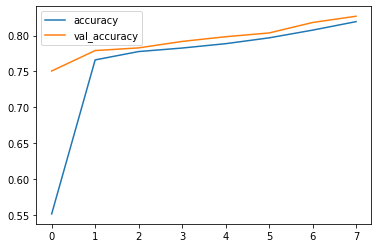

In [97]:
plt.figure(figsize=(15,5))
loss=pd.DataFrame(model.history.history)
loss=loss[['accuracy','val_accuracy']]
loss.plot()

In [98]:
s = model.predict([encoder_input_data[:10],decoder_input_data[:10]])

In [99]:
def decodeTextSeq(seq):
  text = ""

  for id in seq[1:]:
    input = idx2word.get(id)
    if input == None:
      continue
    text += input + " "

    
  return text

In [101]:
result = pd.DataFrame(columns = ["actual","pred"])
for i in range(0,10):
  actual = decodeTextSeq(decoder_input_data[i])
  pred = decodeTextSeq(np.argmax(s[i],axis=1))
  result = result.append({'actual': actual,'pred':pred}, ignore_index=True)

pd.set_option('display.max_rows', None)


print(result["actual"][5])
print(result["pred"][5])

select distinct uri where http dbpedia org resource joe pass http dbpedia org ontology associatedband uri http dbpedia org resource dream dancing album 
select distinct uri where http dbpedia org resource joe demi http dbpedia org ontology associatedband uri http dbpedia org resource buddhism endxxx endxxx 
